In [2]:
%who

Interactive namespace is empty.


In [3]:
import xarray as xr
import numpy as np
import geopandas as gpd
import datetime
import matplotlib
import pandas as pd
import seaborn as sns

#%run -i drought_2017to2019/dataInfo_and_functions.py

In [8]:
def calc_areaAvg(da, latName = 'lat', lonName = 'lon'): 
    weights = np.cos(np.deg2rad(da[latName]))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.mean([latName, lonName])
    return weighted_mean

def calc_regAvg_monAnom_masked(da_monAnom, da_monRef, da_mask):
    da_anom_regAvg = calc_areaAvg(da_monAnom*da_mask)
    da_ref_regAvg = calc_areaAvg(da_monRef*da_mask)
    da_ref_regAvg_forPerc = da_ref_regAvg.sel(month = da_anom_regAvg['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_regAvg.time.values})
    da_anom_regAvg_perc = da_anom_regAvg/da_ref_regAvg_forPerc*100
    return [da_anom_regAvg, da_anom_regAvg_perc]

In [9]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/agcd_othervar/'

agcd_file1 = 'vapourpres_agcd_monthly_1971_2020.nc'
agcd_file2 = 'vapourpres_agcd_monthly_2020_2022.nc'

# get data upto the end of year 2019 from this file
ds_agcd1 = xr.open_dataset(data_dir + agcd_file1)
ds_agcd1 = ds_agcd1.sel(time = slice(None, '2019'))

# get data for 2020 to 2021 from this file & reassign the time coords
ds_agcd2 = xr.open_dataset(data_dir + agcd_file2)
ds_agcd2 = ds_agcd2.sel(time = slice('2020', '2021'))
ds_agcd2 = ds_agcd2.assign_coords({'time': ds_agcd2.time.values +  pd.Timedelta(-15, 'D')})

# the concated agcd data
ds_agcd = xr.concat([ds_agcd1, ds_agcd2], dim = 'time')

# get the saturation vapour pressure calculated from Tmax
ds_esat = xr.open_dataset(data_dir + 'esat_from_tmax_mean_r005_monthly_1971_2021.nc')

da_vpd = ds_esat['esat'] - (ds_agcd['vapourpres']/10)

# the monthly climatology from long-term data
# time_slice = slice('1981-01-01', '2020-05-31')
# time_slice = slice('1980-01-01', '2016-12-31')  # using the agreed time reference

time_slice = slice('2002-01-01', '2016-12-31')   # changing baseline to be consistent with vegetation datasets
da_vpd_lt_monClim = da_vpd.sel(time = time_slice).groupby('time.month').mean('time')

# the monthly anomalies during the drought period
time_slice = slice('2016-01-01', '2020-12-31')
da_vpd_monAnom = da_vpd.sel(time = time_slice).groupby('time.month') - da_vpd_lt_monClim

# read mask from saved files
mask_file = '/g/data/w97/ad9701/drought_2017to2020/AGCD_mask_drought_focusArea.nc'
ds_agcd_mask = xr.open_dataset(mask_file)
da_agcd_mask = ds_agcd_mask['mask']

vpd_anom_list = calc_regAvg_monAnom_masked(da_vpd_monAnom, da_vpd_lt_monClim, da_agcd_mask)

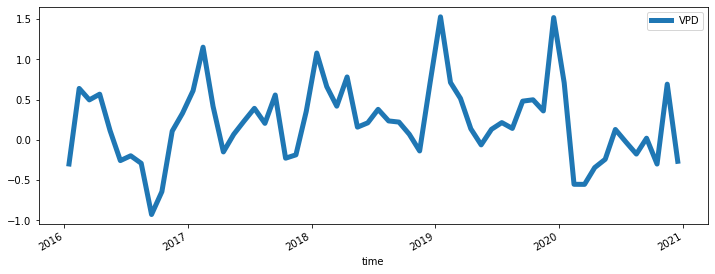

In [10]:
import matplotlib.pyplot as plt
vpd_anom_list[0].plot(size=4, aspect=3,label='VPD', linewidth=5)
plt.legend()

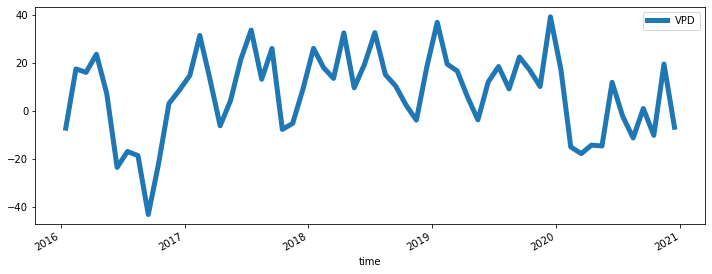

In [11]:
vpd_anom_list[1].plot(size=4, aspect=3,label='VPD', linewidth=5)
plt.legend()

### Temperature

In [12]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/agcd_othervar/'

agcd_tmax = 'agcd_v1_tmax_mean_r005_monthly_1910_2021.nc'
agcd_tmin = 'agcd_v1_tmin_mean_r005_monthly_1910_2021.nc'

ds_tmax = xr.open_dataset(data_dir + agcd_tmax)
ds_tmin = xr.open_dataset(data_dir + agcd_tmin)

# the monthly climatology from long-term data
# time_slice = slice('1981-01-01', '2020-05-31')
# time_slice = slice('1980-01-01', '2016-12-31')  # using the agreed time reference

# using the original baseline to be consistent with precipitation
time_slice = slice('1980-01-01', '2016-12-31')
# time_slice = slice('2002-01-01', '2016-12-31')   # changing baseline to be consistent with vegetation datasets

da_tmax_lt_monClim = ds_tmax['tmax'].sel(time = time_slice).groupby('time.month').mean('time')
da_tmin_lt_monClim = ds_tmin['tmin'].sel(time = time_slice).groupby('time.month').mean('time')

# the monthly anomalies during the drought period
time_slice = slice('2016-01-01', '2020-12-31')
da_tmax_monAnom = ds_tmax['tmax'].sel(time = time_slice).groupby('time.month') - da_tmax_lt_monClim
da_tmin_monAnom = ds_tmin['tmin'].sel(time = time_slice).groupby('time.month') - da_tmin_lt_monClim

# read mask from saved files
mask_file = '/g/data/w97/ad9701/drought_2017to2020/AGCD_mask_drought_focusArea.nc'
ds_agcd_mask = xr.open_dataset(mask_file)
da_agcd_mask = ds_agcd_mask['mask']

tmax_anom_list = calc_regAvg_monAnom_masked(da_tmax_monAnom, da_tmax_lt_monClim, da_agcd_mask)
tmin_anom_list = calc_regAvg_monAnom_masked(da_tmin_monAnom, da_tmin_lt_monClim, da_agcd_mask)

## Plot both

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

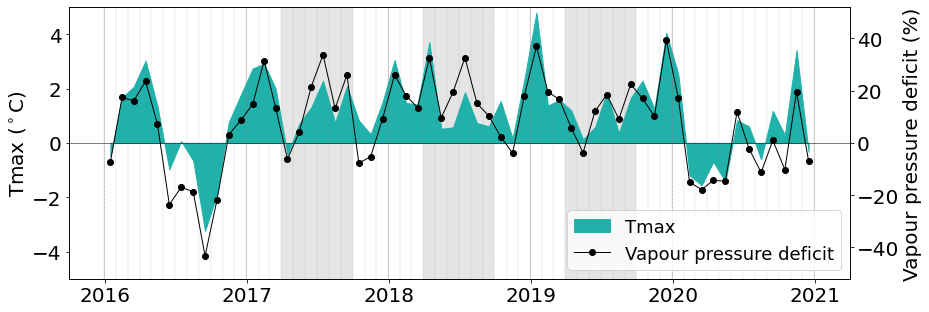

In [14]:
import pandas as pd

out_dir = 'figures/drought_2017to2020/timeseries_plots/'
data_list = [vpd_anom_list[1], tmax_anom_list[0]] #, tmin_anom_list[0]] #, da_E_monAnomAvg_regAvg]
data_names = ['Vapour pressure deficit', 'Tmax'] #, 'Tmin']
#data_col = ['lightseagreen', 'black'] #, 'grey']
data_col = ['black', 'lightseagreen']

AMJJAS_fillcol = 'grey'
AMJJAS_alpha = 0.2

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height
ax2 = ax.twinx()
axis_list = [ax, ax2] #, ax2]

mon_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1)#.to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6)#.to_numpy()

#************* AMJJAS & DJF bars code *******
# AMJJAS_time = pd.date_range(start = '2016-06-30', end = '2020-06-30', periods=5).to_numpy()
# AMJJAS_time = [x.astype('datetime64[D]') for x in AMJJAS_time]
# DJF_time = pd.date_range(start = '2017-01-15', end = '2020-01-15', periods=4).to_numpy()
# DJF_time = [x.astype('datetime64[D]') for x in DJF_time]

# AMJJAS_bars = []
# mon_sel = [4, 5, 6, 7, 8, 9]
# for da in data_list:
#     da_sel = da.sel(time = da.time.dt.month.isin(mon_sel))
#     da_AMJJAS_byyear = da_sel.groupby('time.year').mean()
#     AMJJAS_bars.append(da_AMJJAS_byyear.values)

# DJF_bars = []
# mon_sel = [12, 1, 2]
# for da in data_list:
#     da_seas_temp = da.resample(time="QS-DEC").mean()
#     da_seas_sel = da_seas_temp.sel(time = da_seas_temp.time.dt.month.isin([12, 1, 2]))
#     DJF_bars.append(da_seas_sel.values[1:-1])
    
# for axis, array_val,col in zip(axis_list,AMJJAS_bars,data_col):
#     axis.bar(AMJJAS_time, array_val, width=183, edgecolor='white', color=col, alpha=0.2)

# for axis,array_val,col in zip(axis_list,DJF_bars,data_col):
#     axis.bar(DJF_time, array_val, width=90, edgecolor='white', color=col, alpha=0.2)
#********************************************

# plot gridlines for time
for xline in mon_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

# for axis,da, color, label in zip(axis_list,data_list, data_col, data_names):       
#     axis.plot(da.time.values, da.values, color=color, marker="o", linewidth=1, label=label)

# A filled line for temperature
ax.fill_between(data_list[1].time.values, 0, data_list[1].values, color=data_col[1], label=data_names[1], zorder = 3, alpha = 1)

# A line plot for VPD
ax2.plot(data_list[0].time.values, data_list[0].values, marker='o', color=data_col[0], label=data_names[0], linewidth=1, zorder = 2)
    
plt.xlabel('')
ax.set_ylabel('Tmax ($^\circ$C)')
ax2.set_ylabel('Vapour pressure deficit (%)')
ax2.set_ylim((-52, 52))
ax.set_ylim((-5, 5))

#********** shading the background to indicate the AMJJAS seasons within 2017-19 instead of bars
dx = mon_breaks
# adding march in the below code as breaks are at the end of the month
fill = (mon_breaks.month.isin([3, 4, 5, 6, 7, 8, 9])) & (mon_breaks.year.isin([2017, 2018, 2019]))
ax.fill_between(dx, ax.get_ylim()[0], ax.get_ylim()[1], where=fill, fc=AMJJAS_fillcol, alpha=AMJJAS_alpha, zorder = 1)
#**********

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=data_col[1], edgecolor=data_col[1],label=data_names[1]),
                   Line2D([0], [0], color=data_col[0], marker='o', lw=1, label=data_names[0])]

ax2.legend(handles=legend_elements, loc=4)

fig.savefig(out_dir + 'areaAvg_vpd_perc_and_Tmax_anom_from_monClim_VPDref2002to16_TmaxRef1980to2016.png', bbox_inches='tight', dpi=300)
fig.savefig(out_dir + 'areaAvg_vpd_perc_and_Tmax_anom_from_monClim_VPDref2002to16_TmaxRef1980to2016.pdf', bbox_inches='tight', format='pdf')

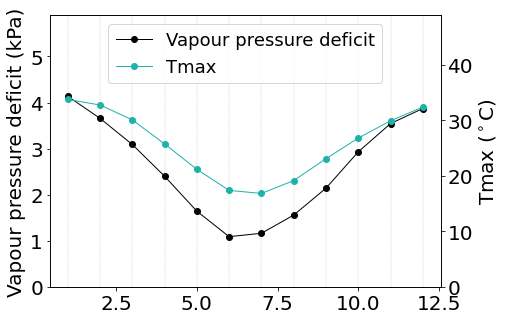

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(7,5)) #width, height
ax2 = ax.twinx()

axis_list = [ax, ax2]

data_list = [calc_areaAvg(da_vpd_lt_monClim*da_agcd_mask), 
             calc_areaAvg(da_tmax_lt_monClim*da_agcd_mask)]

for xline in range(1, 13):
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
    
for da, color, label, axis in zip(data_list, data_col, data_names, axis_list):  
    axis.plot(da.month.values, da.values, color=color, marker="o", linewidth=1, label=label)

plt.xlabel('month')
ax2.set_ylabel('Tmax ($^\circ$C)')
ax.set_ylabel('Vapour pressure deficit (kPa)')
ax.set_ylim((0, 5.9))
ax2.set_ylim((0, 49))

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=data_col[0], lw=1, marker="o",label=data_names[0]),
                   Line2D([0], [0], color=data_col[1], lw=1, marker="o",label=data_names[1])]

ax2.legend(handles=legend_elements, loc='upper center')

fig.savefig(out_dir + 'vpd_and_Tmax_monClim_VPDref2002to16_TmaxRef1980to2016.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'vpd_and_Tmax_monClim_VPDref2002to16_TmaxRef1980to2016.pdf', bbox_inches='tight', format='pdf')

### VPD anomalies

In [26]:
# calculating absolute values for csv anomaly files

data_list = [vpd_anom_list[0], tmax_anom_list[0]]

AMJJAS_bars = []
mon_sel = [4, 5, 6, 7, 8, 9]
for da in data_list:
    da_sel = da.sel(time = da.time.dt.month.isin(mon_sel))
    da_AMJJAS_byyear = da_sel.groupby('time.year').mean()
    AMJJAS_bars.append(da_AMJJAS_byyear.values)

DJF_bars = []
mon_sel = [12, 1, 2]
for da in data_list:
    da_seas_temp = da.resample(time="QS-DEC").mean()
    da_seas_sel = da_seas_temp.sel(time = da_seas_temp.time.dt.month.isin([12, 1, 2]))
    DJF_bars.append(da_seas_sel.values[1:-1])

In [15]:
! mkdir /g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_2002to2016

In [27]:
out_dir = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_2002to2016/'

AMJJAS_time = pd.date_range(start = '2016-06-30', end = '2020-06-30', periods=5).to_numpy()
AMJJAS_time = [x.astype('datetime64[D]') for x in AMJJAS_time]

DJF_time = pd.date_range(start = '2017-01-15', end = '2020-01-15', periods=4).to_numpy()
DJF_time = [x.astype('datetime64[D]') for x in DJF_time]

da_vpd_monClim = calc_areaAvg(da_vpd_lt_monClim*da_agcd_mask)
vname = 'vpd'
unit = 'kPa'

da_anom_allDatamean = vpd_anom_list[0]
da_clim_allDatamean = da_vpd_monClim

mon_sel = [4, 5, 6, 7, 8, 9]
AMJJAS_clim = da_vpd_monClim.sel(month = da_vpd_monClim.month.isin(mon_sel)).mean()

mon_sel = [12, 1, 2]
DJF_clim = da_vpd_monClim.sel(month = da_vpd_monClim.month.isin(mon_sel)).mean()

df_anom = pd.DataFrame({'season':['AMJJAS']*5,
                        'time': AMJJAS_time,
                        'anomaly (' + unit + ')': np.round(AMJJAS_bars[0], 2),
                        'perc_anomaly (%)': np.round(AMJJAS_bars[0]/AMJJAS_clim.values*100,1),
                       'climatology (' + unit + ')': [np.round(AMJJAS_clim.values, 2)]*5})
print(df_anom)
out_file = out_dir + 'AMJJAS_' + vname + '_anomalies.csv'
df_anom.to_csv(out_file)

df_anom = pd.DataFrame({'season':['DJF']*4,
                        'time': DJF_time,
                        'anomaly (' + unit + ')': np.round(DJF_bars[0], 2),
                        'perc_anomaly (%)': np.round(DJF_bars[0]/DJF_clim.values*100,1),
                       'climatology (' + unit + ')': [np.round(DJF_clim.values, 2)]*4})
print(df_anom)
out_file =  out_dir + 'DJF_' + vname + '_anomalies.csv'
df_anom.to_csv(out_file)


anom_seasMean = da_anom_allDatamean.resample(time="QS-DEC").mean()
clim_seasMean = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_anom_allDatamean.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (' + unit + ')': np.round(anom_seasMean, 2).values,
                        'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (' + unit + ')': np.round(clim_seasMean, 2).values})
print(df_anom)

out_file = out_dir + 'seas_' + vname + '_anomalies.csv'
df_anom.to_csv(out_file)

anom_mon = da_anom_allDatamean
clim_mon = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_allDatamean.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (' + unit + ')': np.round(anom_mon, 2).values,
                        'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (' + unit + ')': np.round(clim_mon, 2).values})
print(df_anom_mon)
out_file_mon = out_dir + 'mon_' + vname + '_anomalies.csv'
df_anom_mon.to_csv(out_file_mon)

   season       time  anomaly (kPa)  perc_anomaly (%)  climatology (kPa)
0  AMJJAS 2016-06-30          -0.16              -9.9               1.67
1  AMJJAS 2017-06-30           0.22              13.1               1.67
2  AMJJAS 2018-06-30           0.33              19.9               1.67
3  AMJJAS 2019-06-30           0.17              10.5               1.67
4  AMJJAS 2020-06-30          -0.11              -6.4               1.67
  season       time  anomaly (kPa)  perc_anomaly (%)  climatology (kPa)
0    DJF 2017-01-15           0.70              17.9               3.89
1    DJF 2018-01-15           0.70              17.9               3.89
2    DJF 2019-01-15           0.98              25.2               3.89
3    DJF 2020-01-15           0.56              14.4               3.89
       season  anomaly (kPa)  perc_anomaly (%)  climatology (kPa)
0  2015-12-01           0.17               4.4               3.90
1  2016-03-01           0.39              16.6               2.38
2  2

### Tmax

In [29]:
da_monClim = calc_areaAvg(da_tmax_lt_monClim*da_agcd_mask)
vname = 'tmax'
unit = 'degC'

da_anom_allDatamean = tmax_anom_list[0]
da_clim_allDatamean = da_monClim

mon_sel = [4, 5, 6, 7, 8, 9]
AMJJAS_clim = da_tmax_lt_monClim.sel(month = da_monClim.month.isin(mon_sel)).mean()

mon_sel = [12, 1, 2]
DJF_clim = da_tmax_lt_monClim.sel(month = da_monClim.month.isin(mon_sel)).mean()

df_anom = pd.DataFrame({'season':['AMJJAS']*5,
                        'time': AMJJAS_time,
                        'anomaly (' + unit + ')': np.round(AMJJAS_bars[0], 2),
                        #'perc_anomaly (%)': np.round(AMJJAS_bars[0]/AMJJAS_clim.values*100,1),
                       'climatology (' + unit + ')': [np.round(AMJJAS_clim.values, 2)]*5})
print(df_anom)
out_file = out_dir + 'AMJJAS_' + vname + '_anomalies.csv'
df_anom.to_csv(out_file)

df_anom = pd.DataFrame({'season':['DJF']*4,
                        'time': DJF_time,
                        'anomaly (' + unit + ')': np.round(DJF_bars[0], 2),
                        #'perc_anomaly (%)': np.round(DJF_bars[0]/DJF_clim.values*100,1),
                       'climatology (' + unit + ')': [np.round(DJF_clim.values, 2)]*4})
print(df_anom)
out_file = out_dir + 'DJF_' + vname + '_anomalies.csv'
df_anom.to_csv(out_file)


anom_seasMean = da_anom_allDatamean.resample(time="QS-DEC").mean()
clim_seasMean = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_anom_allDatamean.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (' + unit + ')': np.round(anom_seasMean, 2).values,
                        #'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (' + unit + ')': np.round(clim_seasMean, 2).values})
print(df_anom)

out_file = out_dir + 'seas_' + vname + '_anomalies.csv'
df_anom.to_csv(out_file)

anom_mon = da_anom_allDatamean
clim_mon = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_allDatamean.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (' + unit + ')': np.round(anom_mon, 2).values,
                        #'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (' + unit + ')': np.round(clim_mon, 2).values})
print(df_anom_mon)
out_file_mon = out_dir + 'mon_' + vname + '_anomalies.csv'
df_anom_mon.to_csv(out_file_mon)

   season       time  anomaly (degC)  climatology (degC)
0  AMJJAS 2016-06-30           -0.16           20.209999
1  AMJJAS 2017-06-30            0.22           20.209999
2  AMJJAS 2018-06-30            0.33           20.209999
3  AMJJAS 2019-06-30            0.17           20.209999
4  AMJJAS 2020-06-30           -0.11           20.209999
  season       time  anomaly (degC)  climatology (degC)
0    DJF 2017-01-15            0.70           28.709999
1    DJF 2018-01-15            0.70           28.709999
2    DJF 2019-01-15            0.98           28.709999
3    DJF 2020-01-15            0.56           28.709999
       season  anomaly (degC)  climatology (degC)
0  2015-12-01            0.29               33.58
1  2016-03-01            1.82               26.01
2  2016-06-01           -0.83               18.09
3  2016-09-01           -2.23               27.38
4  2016-12-01            2.15               33.30
5  2017-03-01            0.43               26.01
6  2017-06-01            1.1

### GRACE

In [45]:
anom_seasMean = da_lwe_monAnom_regAvg_wNan.resample(time="QS-DEC").mean()
clim_seasMean = da_lwe_monClim_regAvg.sel(month = da_lwe_monAnom_regAvg_wNan['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_lwe_monAnom_regAvg_wNan.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (cm)': np.round(anom_seasMean, 5).values,
                        #'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (cm)': np.round(clim_seasMean, 5).values})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/seas_grace_anomalies.csv'
df_anom.to_csv(out_file)

       season  anomaly (cm)  climatology (cm)
0  2015-12-01       1.74641           2.69362
1  2016-03-01       0.72958           2.58601
2  2016-06-01       2.94551           4.91844
3  2016-09-01       3.87797           4.09212
4  2016-12-01       2.83905           2.71904
5  2017-03-01       2.34506           2.58601
6  2017-06-01       0.48230           4.91844
7  2017-09-01           NaN           4.09212
8  2017-12-01           NaN           2.71904
9  2018-03-01           NaN           2.58601
10 2018-06-01      -5.07396           4.91844
11 2018-09-01      -2.87397           4.09212
12 2018-12-01      -4.08288           2.71904
13 2019-03-01      -4.07245           2.58601
14 2019-06-01      -5.68912           4.91844
15 2019-09-01      -4.94951           4.09212
16 2019-12-01      -5.85020           2.71904
17 2020-03-01      -0.16168           2.58601
18 2020-06-01      -1.70123           4.91844
19 2020-09-01      -0.73444           4.09212
20 2020-12-01      -0.74733       

In [46]:
anom_mon = da_lwe_monAnom_regAvg_wNan
clim_mon = da_lwe_monClim_regAvg.sel(month = da_lwe_monAnom_regAvg_wNan['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_lwe_monAnom_regAvg_wNan.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (cm)': np.round(anom_mon, 5).values,
                        #'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (sm)': np.round(clim_mon, 5).values})
print(df_anom_mon)
out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/mon_grace_anomalies.csv'
df_anom_mon.to_csv(out_file_mon)

                 month  anomaly (cm)  climatology (sm)
0  2016-01-16 12:00:00       3.49882           2.45717
1  2016-02-14 00:00:00      -0.00600           2.93007
2  2016-03-16 12:00:00      -0.46540           2.96466
3  2016-04-15 00:00:00           NaN           3.05141
4  2016-05-20 00:00:00       1.92455           1.74197
5  2016-06-16 00:00:00       2.31034           3.80749
6  2016-07-15 12:00:00       3.23161           5.67097
7  2016-08-21 12:00:00       3.29457           5.27686
8  2016-09-15 00:00:00           NaN           5.11933
9  2016-10-15 00:00:00           NaN           3.53804
10 2016-11-27 12:00:00       3.87797           3.61900
11 2016-12-24 12:00:00       4.15766           2.76986
12 2017-01-21 00:00:00       1.52043           2.45717
13 2017-02-15 00:00:00           NaN           2.93007
14 2017-03-31 12:00:00       1.68782           2.96466
15 2017-04-24 12:00:00       1.76912           3.05141
16 2017-05-12 12:00:00       3.57822           1.74197
17 2017-06

In [50]:
da_grace_monClim = da_lwe_monClim_regAvg

mon_sel = [4, 5, 6, 7, 8, 9]
grace_AMJJAS_clim = da_grace_monClim.sel(month = da_grace_monClim.month.isin(mon_sel)).mean()

mon_sel = [12, 1, 2]
grace_DJF_clim = da_grace_monClim.sel(month = da_grace_monClim.month.isin(mon_sel)).mean()

df_anom = pd.DataFrame({'season':['AMJJAS']*5,
                        'time': AMJJAS_time,
                        'anomaly (cm)': np.round(AMJJAS_bars[1], 2),
                        #'perc_anomaly (%)': np.round(AMJJAS_bars[1]/grace_AMJJAS_clim.values*100,1),
                       'climatology (cm)': [np.round(grace_AMJJAS_clim.values, 2)]*5})
print(df_anom)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/AMJJAS_grace_anomalies.csv'
df_anom.to_csv(out_file)

df_anom = pd.DataFrame({'season':['DJF']*4,
                        'time': DJF_time,
                        'anomaly (cm)': np.round(DJF_bars[1], 2),
                        #'perc_anomaly (%)': np.round(DJF_bars[1]/grace_DJF_clim.values*100,1),
                       'climatology (cm)': [np.round(grace_DJF_clim.values, 2)]*4})

print(df_anom)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/DJF_grace_anomalies.csv'
df_anom.to_csv(out_file)

   season       time  anomaly (cm)  climatology (cm)
0  AMJJAS 2016-06-30          2.69              4.11
1  AMJJAS 2017-06-30          1.94              4.11
2  AMJJAS 2018-06-30         -5.07              4.11
3  AMJJAS 2019-06-30         -4.86              4.11
4  AMJJAS 2020-06-30         -1.11              4.11
  season       time  anomaly (cm)  climatology (cm)
0    DJF 2017-01-15          2.84              2.72
1    DJF 2018-01-15           NaN              2.72
2    DJF 2019-01-15         -4.08              2.72
3    DJF 2020-01-15         -5.85              2.72
